# Set-up

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_theme()

In [2]:
 # Handling summer and winter time
hour_loss_days = [
    20170326,
    20180325,
    20190331,
    20200329,
    20210328,
    20220327
]
hour_gain_days = [
    20171029,
    20181028,
    20191027,
    20201025,
    20211031,
    20221030
]

In [3]:
def correct_date_hour(df):
    """Corrects the date and the hour of a dataframe having a `date` in int YYYYMMDD format and an `hour` column
    to match the GME system (which accounts for the daylight saving time with a missing 24th hour for the
    hour loss day and an additional 25th hour for the hour gain day)
    """
    # Creates a date-hour int in the YYYYMMDDHH format
    df['datehour'] = (df['date'].astype(str) + df['hour'].apply(lambda x: "{:02d}".format(x))).astype(int)

    # Shifted values correspond the to the values of the next line (so the day after)
    df['shift_date'] = df['date'].shift(-1)
    df['shift_hour'] = df['hour'].shift(-1)

    for loss_day, gain_day in zip(hour_loss_days, hour_gain_days):
        # Hours between the loss day and the gain day have to be corrected
        hours_to_shift = (df.datehour > int(str(loss_day) + '23')) & (df.datehour < int(str(gain_day) + '24'))
        # Additional hour on the gain day
        new_hour = df.datehour == int(str(gain_day) + '24')

        df.loc[hours_to_shift, 'date'] = df.loc[hours_to_shift, 'shift_date']
        df.loc[hours_to_shift, 'hour'] = df.loc[hours_to_shift, 'shift_hour']
        
        # The new hour is labeled as the 25th hour
        df.loc[new_hour, 'hour'] = 25
    
    df.drop(['datehour', 'shift_date', 'shift_hour'], axis=1, inplace=True)

# Read

## Structural data

In [4]:
struct_df = pd.read_pickle('../data/2_processed/PC_strut.pickle')
struct_df.head()

,SC_PC1,SC_PC2,IN_PC1,IN_PC2,CT_PC1,CT_PC2
2018-01-01 00:00:00,1.023687,0.433872,-3.072079,-0.745118,0.717989,3.241352
2018-01-01 01:00:00,0.787333,0.214727,-3.269953,-0.389639,0.717989,3.241352
2018-01-01 02:00:00,1.142582,0.517246,-3.511562,-0.682966,0.717989,3.241352
2018-01-01 03:00:00,1.359091,0.692018,-3.635374,-0.274023,0.717989,3.241352
2018-01-01 04:00:00,1.640151,0.729753,-3.703611,-0.167476,1.093151,3.534880


## Exogenous and calendar data

In [5]:

date_df = pd.read_excel('../data/2_processed/Dati_per_data_1722.xlsx')
date_df.head()

,DATE,HOUR,PzNORD,acquistiMGP,venditeMGP,tecMarg,Pgas,angolosolare,angolodecl,ggsett
0,01/01/2017,1,53.00,11230.358,12531.020,Oliocarbone,19.9,-178.226106,-23.011637,holiday
1,01/01/2017,2,52.00,10658.639,12173.974,Oliocarbone,19.9,-163.226106,-23.011637,holiday
2,01/01/2017,3,51.00,10143.646,10991.049,Ccgt,19.9,-148.226106,-23.011637,holiday
3,01/01/2017,4,47.27,9847.938,9706.109,Ccgt,19.9,-133.226106,-23.011637,holiday
4,01/01/2017,5,45.49,9610.943,8797.656,Ccgt,19.9,-118.226106,-23.011637,holiday


## Unit data

In [6]:

unit_df = pd.read_excel('../data/2_processed/Dati_per_unita.xlsx')
unit_df.head()

,unit,prov,type
0,UP_ACTV_1,Vercelli,Thermoelectric
1,UP_ALTOADDA_1,Milano,Hydro Run-of-river and poundage
2,UP_ARSIE_1,Belluno,Hydro Run-of-river and poundage
3,UP_AZOTATI_5,Venezia,Fossil Gas
4,UP_BARGI_CEN_1,Bologna,Hydro Pumped Storage


## Market data

In [7]:
market_df = pd.read_parquet('../data/1_input/5_DatiOfferta/MSD_bids_with_program.parquet')
# Drop 2017 since structural data is missing for that year
market_df = market_df[market_df.BID_OFFER_DATE_DT > 20171231] 
market_df.head()

,BID_OFFER_DATE_DT,INTERVAL_NO,UNIT_REFERENCE_NO,PURPOSE_CD,ACCEPTED,AWARDED_QUANTITY_NO,ADJ_QUANTITY_NO,AS_AWARDED_QUANTITY_NO,AS_ADJ_QUANTITY_NO,OFFERED_PRICE,mgp_mi_binding_program
2091226,20180101,1,UP_ALTOADDA_1,BID,False,0.0,0.0,0.0,0.0,18.11,0.0
2091227,20180101,1,UP_ALTOADDA_1,OFF,False,0.0,195.5,0.0,0.0,111.74,0.0
2091228,20180101,2,UP_ALTOADDA_1,BID,False,0.0,0.0,0.0,0.0,18.11,0.0
2091229,20180101,2,UP_ALTOADDA_1,OFF,False,0.0,195.5,0.0,0.0,111.74,0.0
2091230,20180101,3,UP_ALTOADDA_1,BID,False,0.0,0.0,0.0,0.0,18.11,0.0


# Merge

## Initialise output dataset

In [8]:
market_df_off = market_df.loc[market_df.PURPOSE_CD == 'OFF', ['BID_OFFER_DATE_DT', 'INTERVAL_NO', 'UNIT_REFERENCE_NO', 'ADJ_QUANTITY_NO', 'AS_ADJ_QUANTITY_NO']]
market_df_bid = market_df.loc[market_df.PURPOSE_CD == 'BID', ['BID_OFFER_DATE_DT', 'INTERVAL_NO', 'UNIT_REFERENCE_NO', 'ADJ_QUANTITY_NO', 'AS_ADJ_QUANTITY_NO']]

merge_df = market_df.merge(
    market_df_off,
    how='left',
    on=['BID_OFFER_DATE_DT', 'INTERVAL_NO',	'UNIT_REFERENCE_NO'],
    suffixes=[None, "_OFF"]
)

merge_df = merge_df.merge(
    market_df_bid,
    how='left',
    on=['BID_OFFER_DATE_DT', 'INTERVAL_NO',	'UNIT_REFERENCE_NO'],
    suffixes=[None, "_BID"]
)

merge_df.set_index(market_df.index, inplace=True)

market_df['OFF_QUANTITY'] = merge_df['ADJ_QUANTITY_NO_OFF']
market_df['BID_QUANTITY'] = merge_df['ADJ_QUANTITY_NO_BID']

market_df['AS_OFF_QUANTITY'] = merge_df['AS_ADJ_QUANTITY_NO_OFF']
market_df['AS_BID_QUANTITY'] = merge_df['AS_ADJ_QUANTITY_NO_BID']

In [9]:
# Taking only the bids for which a quantity is proposed
print(len(market_df))
market_df = market_df.loc[((market_df['OFF_QUANTITY'] > 0) & (market_df['PURPOSE_CD'] == 'OFF')) | ((market_df['BID_QUANTITY'] > 0) & (market_df['PURPOSE_CD'] == 'BID'))]
print(len(market_df))

10889598
5771266


In [10]:
index = market_df.BID_OFFER_DATE_DT.astype(str) + market_df.INTERVAL_NO.astype(str) + market_df.UNIT_REFERENCE_NO + '_' + market_df.PURPOSE_CD
df = pd.DataFrame(index=index)

market_df.set_index(index, inplace=True)

In [11]:
df['hour'] = market_df.INTERVAL_NO
df['date'] = market_df.BID_OFFER_DATE_DT
df['year'] = df.date.astype(str).str[:4].astype(int)
df['unit'] = market_df.UNIT_REFERENCE_NO
df['scope'] = market_df['PURPOSE_CD']


## Add structural data

In [12]:
struct_cols = struct_df.columns
struct_df['date'] = struct_df.index.strftime('%Y%m%d').astype(int)
struct_df['hour'] = struct_df.index.hour + 1

correct_date_hour(struct_df)
struct_df

,SC_PC1,SC_PC2,IN_PC1,IN_PC2,CT_PC1,CT_PC2,date,hour
2018-01-01 00:00:00,1.023687,0.433872,-3.072079,-0.745118,0.717989,3.241352,20180101,1
2018-01-01 01:00:00,0.787333,0.214727,-3.269953,-0.389639,0.717989,3.241352,20180101,2
2018-01-01 02:00:00,1.142582,0.517246,-3.511562,-0.682966,0.717989,3.241352,20180101,3
2018-01-01 03:00:00,1.359091,0.692018,-3.635374,-0.274023,0.717989,3.241352,20180101,4
2018-01-01 04:00:00,1.640151,0.729753,-3.703611,-0.167476,1.093151,3.534880,20180101,5
...,...,...,...,...,...,...,...,...
2022-12-31 19:00:00,-0.029177,-2.330178,-1.385200,0.630366,-2.484197,1.335766,20221231,20
2022-12-31 20:00:00,-0.075154,-0.954465,-1.872673,0.745683,-2.449869,1.383184,20221231,21
2022-12-31 21:00:00,2.244316,-3.847872,-2.345759,0.833482,-2.547642,1.441204,20221231,22
2022-12-31 22:00:00,2.277886,-3.849805,-2.698679,0.834434,-2.527069,1.452952,20221231,23


In [13]:

merge_df = df[['date', 'hour']].merge(
    struct_df,
    how='left',
    on=['date', 'hour']
)

merge_df.set_index(index, inplace=True)

In [14]:
df[struct_cols] = merge_df[struct_cols]
df.head(3)

,hour,date,year,unit,scope,SC_PC1,SC_PC2,IN_PC1,IN_PC2,CT_PC1,CT_PC2
201801011UP_ALTOADDA_1_OFF,1,20180101,2018,UP_ALTOADDA_1,OFF,1.023687,0.433872,-3.072079,-0.745118,0.717989,3.241352
201801012UP_ALTOADDA_1_OFF,2,20180101,2018,UP_ALTOADDA_1,OFF,0.787333,0.214727,-3.269953,-0.389639,0.717989,3.241352
201801013UP_ALTOADDA_1_OFF,3,20180101,2018,UP_ALTOADDA_1,OFF,1.142582,0.517246,-3.511562,-0.682966,0.717989,3.241352


## Add exogenous and calendar data

In [15]:
date_df['DATE'] = pd.to_datetime(date_df.DATE, format='%d/%m/%Y').dt.strftime('%Y%m%d').astype(int)
date_df.rename({'DATE': 'date', 'HOUR': 'hour'}, axis=1, inplace=True)

correct_date_hour(date_df)

merge_df = df[['date', 'hour']].merge(
    date_df,
    how='left',
    on=['date', 'hour']
)

merge_df.set_index(index, inplace=True)

In [16]:
df['PurchMGP'] = merge_df['acquistiMGP']
df['SellMGP'] = merge_df['venditeMGP']
df['MargTech'] = merge_df['tecMarg']
df['MGPprice'] = merge_df['PzNORD']
df['GNprice'] = merge_df['Pgas']
df['SolarAngle'] = merge_df['angolosolare']
df['DeclAngle'] = merge_df['angolodecl']
df['WorkDay'] = merge_df['ggsett']
df.head(3)

,hour,date,year,unit,scope,SC_PC1,SC_PC2,IN_PC1,IN_PC2,CT_PC1,CT_PC2,PurchMGP,SellMGP,MargTech,MGPprice,GNprice,SolarAngle,DeclAngle,WorkDay
201801011UP_ALTOADDA_1_OFF,1,20180101,2018,UP_ALTOADDA_1,OFF,1.023687,0.433872,-3.072079,-0.745118,0.717989,3.241352,11661.749,8176.298,Carbone,45.73,20.107,-178.226106,-23.011637,holiday
201801012UP_ALTOADDA_1_OFF,2,20180101,2018,UP_ALTOADDA_1,OFF,0.787333,0.214727,-3.269953,-0.389639,0.717989,3.241352,11095.782,7683.106,Carbone,44.16,20.107,-163.226106,-23.011637,holiday
201801013UP_ALTOADDA_1_OFF,3,20180101,2018,UP_ALTOADDA_1,OFF,1.142582,0.517246,-3.511562,-0.682966,0.717989,3.241352,10709.883,7315.858,Ccgt,42.24,20.107,-148.226106,-23.011637,holiday


## Add unit data

In [17]:
merge_df = df[['unit']].merge(
    unit_df,
    how='left',
    on=['unit']
)

merge_df.set_index(index, inplace=True)

In [18]:
df['Prov'] = merge_df['prov']
df['Tech'] = merge_df['type']
df.head()

,hour,date,year,unit,scope,SC_PC1,SC_PC2,IN_PC1,IN_PC2,CT_PC1,...,PurchMGP,SellMGP,MargTech,MGPprice,GNprice,SolarAngle,DeclAngle,WorkDay,Prov,Tech
201801011UP_ALTOADDA_1_OFF,1,20180101,2018,UP_ALTOADDA_1,OFF,1.023687,0.433872,-3.072079,-0.745118,0.717989,...,11661.749,8176.298,Carbone,45.73,20.107,-178.226106,-23.011637,holiday,Milano,Hydro Run-of-river and poundage
201801012UP_ALTOADDA_1_OFF,2,20180101,2018,UP_ALTOADDA_1,OFF,0.787333,0.214727,-3.269953,-0.389639,0.717989,...,11095.782,7683.106,Carbone,44.16,20.107,-163.226106,-23.011637,holiday,Milano,Hydro Run-of-river and poundage
201801013UP_ALTOADDA_1_OFF,3,20180101,2018,UP_ALTOADDA_1,OFF,1.142582,0.517246,-3.511562,-0.682966,0.717989,...,10709.883,7315.858,Ccgt,42.24,20.107,-148.226106,-23.011637,holiday,Milano,Hydro Run-of-river and poundage
201801014UP_ALTOADDA_1_OFF,4,20180101,2018,UP_ALTOADDA_1,OFF,1.359091,0.692018,-3.635374,-0.274023,0.717989,...,10381.797,6911.034,Carbone,39.29,20.107,-133.226106,-23.011637,holiday,Milano,Hydro Run-of-river and poundage
201801015UP_ALTOADDA_1_OFF,5,20180101,2018,UP_ALTOADDA_1,OFF,1.640151,0.729753,-3.703611,-0.167476,1.093151,...,10236.265,6645.689,Carbone,36.00,20.107,-118.226106,-23.011637,holiday,Milano,Hydro Run-of-river and poundage


## Add market data

$PV$ should be the value indicating the _gauge_ at which the unit is between its minimal capacity (which can be negative for the hydro-pumped storages) and maximal capacity

$$\text{PV}=\frac{|\text{Binding Program}|}{|\text{Binding Program}| + \text{MSD Off Qty}}$$

Note that the absolute values allows to take care of the cases when the binding program is negative, which can be the case for hydro pumped storages

Alternative possibility:
$$\text{PV}=\frac{\text{MSD Bid Qty} + \text{MSD AS Bid Qty}}{\text{MSD Bid Qty} + \text{MSD AS Bid Qty} + \text{MSD Off Qty}}$$
For units without storing capacity, given that we have:
- $\text{MSD Bid Qty} = P-P_{min}$
- $\text{MSD AS Bid Qty} = P_{min}$
- $\text{MSD Off Qty} = P_{max}-P$

$$\text{PV}=\frac{P}{P_{max}}$$

For units with storing capacity (i.e. hydro-pumped storage units), there is no technical minimum, which means that:
- $\text{MSD Bid Qty} = P-P_{min}$, with $P_{min}<0$ being the maximum consumption (negative) power
- $\text{MSD AS Bid Qty} = 0$ (units with storing capacity do not submit start-up or shut-down offers)
- $\text{MSD Off Qty} = P_{max}-P$

$$\text{PV}=\frac{P-P_{min}}{P_{max} - P_{min}}$$

In the sum above:
- If the unit has **no downward reserve**, then $P = 0$ for a classic unit or $P = P_{min}<0$ for a storage-enabled unit $\implies \text{PV}=0$
- If the unit has **some downward reserve**, then $P > 0$ for a classic unit or $P > P_{min}$ for a storage-enabled unit $\implies \text{PV}>0$
- If the unit has **no upward reserve** then $P = P_{max} \implies \text{PV}=1$
- If the unit has **no downward nor upward reserve**, then $P_{min}=P_{max}=0$ and the offer (which is actually dummy) has already been removed from the dataset at the beginning

In [19]:
# Binding program just before GR bids
# Binding program after commercial markets + eventual technical minimum (off) or shutdown (bid) accepted before GR bids
binding_program = market_df.mgp_mi_binding_program + market_df.PURPOSE_CD.map({'BID': -1, 'OFF': 1}) * market_df.AS_AWARDED_QUANTITY_NO

# Old formula
market_df['PVold'] = binding_program.abs() / (binding_program.abs() + market_df['OFF_QUANTITY']) # we take absolute value in case of negative binding program (e.g. pumped storage)

# New formula
market_df['PVnew'] = (market_df.BID_QUANTITY + market_df.AS_BID_QUANTITY) / (market_df.BID_QUANTITY + market_df.AS_BID_QUANTITY + market_df.OFF_QUANTITY)

In [20]:
df['PVold'] = market_df['PVold'].round(3)
df['PVnew'] = market_df['PVnew'].round(3)
df['Price'] = market_df['OFFERED_PRICE']
# We take the normalised difference for more robustness, compared to the relative difference
df['PriceDiff'] = ((df['Price'] - df['MGPprice']) / (df['MGPprice'] + df['Price']).abs()).round(3).fillna(0) # The NaN case would occur if MGPPrice = Price = 0
# df['PriceDiff'] = ((df['Price'] - df['MGPprice']) / (df['MGPprice']).abs()).round(3)
#df.loc[df.MGPprice == 0, 'PriceDiff'] = 0 # Simple fix for the undetermined case
df['Result'] = market_df['ACCEPTED']
df['RatioAcc'] = market_df['AWARDED_QUANTITY_NO'] / market_df['ADJ_QUANTITY_NO']
df['Qty'] = market_df['ADJ_QUANTITY_NO']

In [21]:
# Correct the hours for the hour loss and gain days, to reflect the real time of the day
# The transformation is the following:
#   - For the loss day: 1, 2, 3, ..., 23 becomes 1, 2, 4, ..., 24
#   - For the gain day: 1, 2, 3, ..., 24, 25 becomes 1, 2, 2, 3, ..., 24
for day in hour_loss_days:
    # The time change occurs at 2am and the data sets the hour from 1 to 23 for these days
    hours_to_shift = (df.date == day) & (df.hour > 2)
    df.loc[hours_to_shift, 'hour'] = df.loc[hours_to_shift, 'hour'] + 1

for day in hour_gain_days:
    # The time change occurs at 2am and the data sets the hour from 1 to 25 for these days
    hours_to_shift = (df.date == day) & (df.hour > 2)
    df.loc[hours_to_shift, 'hour'] = df.loc[hours_to_shift, 'hour'] - 1

In [22]:
df

,hour,date,year,unit,scope,SC_PC1,SC_PC2,IN_PC1,IN_PC2,CT_PC1,...,WorkDay,Prov,Tech,PVold,PVnew,Price,PriceDiff,Result,RatioAcc,Qty
201801011UP_ALTOADDA_1_OFF,1,20180101,2018,UP_ALTOADDA_1,OFF,1.023687,0.433872,-3.072079,-0.745118,0.717989,...,holiday,Milano,Hydro Run-of-river and poundage,0.000,0.000,111.74,0.419,False,0.0,195.500
201801012UP_ALTOADDA_1_OFF,2,20180101,2018,UP_ALTOADDA_1,OFF,0.787333,0.214727,-3.269953,-0.389639,0.717989,...,holiday,Milano,Hydro Run-of-river and poundage,0.000,0.000,111.74,0.433,False,0.0,195.500
201801013UP_ALTOADDA_1_OFF,3,20180101,2018,UP_ALTOADDA_1,OFF,1.142582,0.517246,-3.511562,-0.682966,0.717989,...,holiday,Milano,Hydro Run-of-river and poundage,0.000,0.000,111.74,0.451,False,0.0,195.500
201801014UP_ALTOADDA_1_OFF,4,20180101,2018,UP_ALTOADDA_1,OFF,1.359091,0.692018,-3.635374,-0.274023,0.717989,...,holiday,Milano,Hydro Run-of-river and poundage,0.000,0.000,111.74,0.480,False,0.0,195.500
201801015UP_ALTOADDA_1_OFF,5,20180101,2018,UP_ALTOADDA_1,OFF,1.640151,0.729753,-3.703611,-0.167476,1.093151,...,holiday,Milano,Hydro Run-of-river and poundage,0.000,0.000,111.74,0.513,False,0.0,195.500
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022123121UP_VOGHERA_1_BID,21,20221231,2022,UP_VOGHERA_1,BID,-0.075154,-0.954465,-1.872673,0.745683,-2.449869,...,holiday,Pavia,Fossil Gas,0.573,0.573,143.00,-0.369,False,0.0,18.568
2022123121UP_VOGHERA_1_OFF,21,20221231,2022,UP_VOGHERA_1,OFF,-0.075154,-0.954465,-1.872673,0.745683,-2.449869,...,holiday,Pavia,Fossil Gas,0.573,0.573,320.00,0.016,False,0.0,169.432
2022123122UP_VOGHERA_1_OFF,22,20221231,2022,UP_VOGHERA_1,OFF,2.244316,-3.847872,-2.345759,0.833482,-2.547642,...,holiday,Pavia,Fossil Gas,0.526,0.526,320.00,0.085,False,0.0,188.000
2022123123UP_VOGHERA_1_OFF,23,20221231,2022,UP_VOGHERA_1,OFF,2.277886,-3.849805,-2.698679,0.834434,-2.527069,...,holiday,Pavia,Fossil Gas,0.525,0.525,320.00,0.190,False,0.0,189.000


In [23]:
# Final test to check that there are no NaN values
df[df.isna().any(axis=1)]

,hour,date,year,unit,scope,SC_PC1,SC_PC2,IN_PC1,IN_PC2,CT_PC1,...,WorkDay,Prov,Tech,PVold,PVnew,Price,PriceDiff,Result,RatioAcc,Qty
201801011UP_RIVADEL_3_BID,1,20180101,2018,UP_RIVADEL_3,BID,1.023687,0.433872,-3.072079,-0.745118,0.717989,...,holiday,Trento,Hydro Pumped Storage,NaN,1.0,1.00,-0.957,False,0.0,49.0
201801012UP_RIVADEL_3_BID,2,20180101,2018,UP_RIVADEL_3,BID,0.787333,0.214727,-3.269953,-0.389639,0.717989,...,holiday,Trento,Hydro Pumped Storage,NaN,1.0,1.00,-0.956,False,0.0,49.0
201801013UP_RIVADEL_3_BID,3,20180101,2018,UP_RIVADEL_3,BID,1.142582,0.517246,-3.511562,-0.682966,0.717989,...,holiday,Trento,Hydro Pumped Storage,NaN,1.0,1.00,-0.954,False,0.0,49.0
201801014UP_RIVADEL_3_BID,4,20180101,2018,UP_RIVADEL_3,BID,1.359091,0.692018,-3.635374,-0.274023,0.717989,...,holiday,Trento,Hydro Pumped Storage,NaN,1.0,1.00,-0.950,False,0.0,49.0
201801015UP_RIVADEL_3_BID,5,20180101,2018,UP_RIVADEL_3,BID,1.640151,0.729753,-3.703611,-0.167476,1.093151,...,holiday,Trento,Hydro Pumped Storage,NaN,1.0,1.00,-0.946,False,0.0,49.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022122717UP_ACTV_1_BID,17,20221227,2022,UP_ACTV_1,BID,-0.380528,0.289296,-0.398914,-0.367293,-0.850204,...,weekday,Vercelli,Thermoelectric,NaN,1.0,0.01,-1.000,False,0.0,8.7
2022123013UP_MONFALCO_1_BID,13,20221230,2022,UP_MONFALCO_1,BID,2.080139,-1.386927,-1.102635,1.050806,-2.549760,...,weekday,Gorizia,Fossil Hard coal,NaN,1.0,172.86,0.000,False,0.0,27.0
2022123014UP_MONFALCO_1_BID,14,20221230,2022,UP_MONFALCO_1,BID,1.963160,-1.504157,-1.380546,1.019955,-2.532298,...,weekday,Gorizia,Fossil Hard coal,NaN,1.0,130.00,0.000,False,0.0,27.0
2022123015UP_MONFALCO_1_BID,15,20221230,2022,UP_MONFALCO_1,BID,0.217705,-0.783597,-1.424378,0.860874,-2.532298,...,weekday,Gorizia,Fossil Hard coal,NaN,1.0,195.33,0.000,False,0.0,27.0


In [24]:
# Removing eventual NaN of PVold
df.dropna(subset=['PVold'], inplace=True)
len(df)

5751703

In [25]:
# Final test to check that there are no NaN values
df[df.isna().any(axis=1)]

,hour,date,year,unit,scope,SC_PC1,SC_PC2,IN_PC1,IN_PC2,CT_PC1,...,WorkDay,Prov,Tech,PVold,PVnew,Price,PriceDiff,Result,RatioAcc,Qty


In [26]:
for scope in ['BID', 'OFF']:
    df[df.scope == scope].to_pickle(f'../data/3_output/ML_dataset_{scope}_with_qty_ratio.pkl')

# Tests

In [39]:
na_pv.PURPOSE_CD.value_counts()

PURPOSE_CD
BID    19563
Name: count, dtype: Int64

In [26]:
len(market_df)

5771266

In [29]:
na_pv = market_df[market_df.PV.isna()]
na_pv.ACCEPTED.value_counts(normalize=True)

ACCEPTED
False    0.994684
True     0.005316
Name: proportion, dtype: float64

In [30]:
na_pv.ACCEPTED.value_counts()

ACCEPTED
False    19459
True       104
Name: count, dtype: int64

In [34]:
na_pv['Tech'].value_counts(sort=False)

KeyError: 'Tech'

In [27]:
len(df)

5751703

<Axes: xlabel='year', ylabel='PriceDiff'>

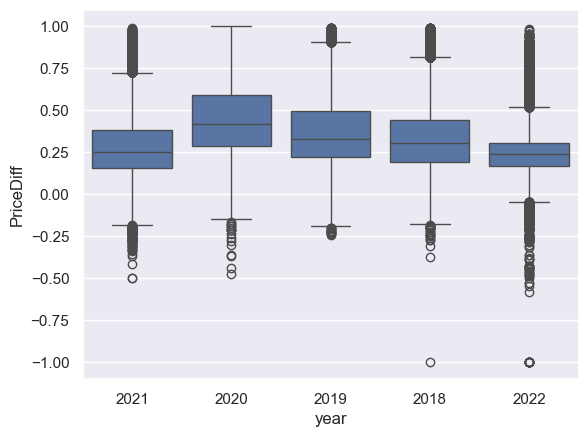

In [44]:
test_df = df.copy()
test_df['year'] = df.date.astype(str).str[:4]

#plt.figure(figsize=(12, 8))
sns.boxplot(
    x = 'year',
    y = 'PriceDiff',
    data = test_df.loc[test_df.scope=='OFF'].sample(frac=0.1),
    #showfliers = False,
    #whis = (2, 98),
    #palette = 'cool',
)

<Axes: >

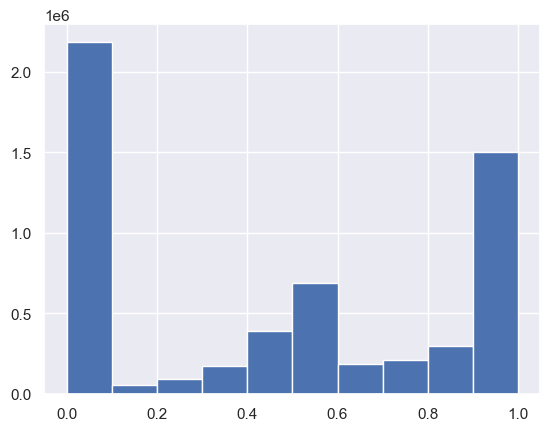

In [42]:
test_df.PV.hist()